# **- Project Background**

- **Obejctive**

Project Data Analysis ini dilakukan untuk untuk menganalisa Shipping and Stock Performance dari Q1 - Q2 tahun 2023, Data yang digunakan untuk kita analisis diperoleh dari database BigQuery “thelook_ecommerce”. Dan untuk menjawab permasalahan tersebut akan dilakukan analisis statistik descriptive, inferential, dan visualisasi data.

- **Problem Breakdown**

Ada beberapa pertanyaan utama yang akan dijawab:

    - Seberapa efisien proses pengiriman?
    - Berapa rata-rata waktu pengiriman dari pesanan dibuat hingga diterima pelanggan?
    - Berapa jumlah pesanan yang berhasil dikirim dan diterima dibandingkan dengan yang dibatalkan?
    - Apakah ada indikasi masalah dalam pengelolaan stok berdasarkan jumlah pesanan yang tidak terkirim?
    - Bagaimana distribusi jumlah barang dalam satu pesanan?
    - Apakah ada perbedaan signifikan dalam waktu pengiriman berdasarkan status pesanan atau faktor lainnya?


# **- Import Libaries**

In [ ]:
# Import library
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind

# **- Data Loading**

In [ ]:
# menghubungkan colab dan BigQuery
auth.authenticate_user()
print('Authenticated')

project_id = "project-shipping-stock"
client = bigquery.Client(project=project_id)

Authenticated


In [ ]:
# Query data hanya untuk periode Q1 - Q2 2023
query = """
SELECT
    order_id,
    user_id,
    status,
    gender,
    created_at,
    returned_at,
    shipped_at,
    delivered_at,
    num_of_item
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE DATE(created_at) BETWEEN '2023-01-01' AND '2023-06-30'
"""
df = client.query(query).to_dataframe()
df.head()

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
0,20,16,Cancelled,F,2023-01-23 16:23:00+00:00,NaT,NaT,NaT,2
1,121,84,Cancelled,F,2023-01-20 04:17:00+00:00,NaT,NaT,NaT,3
2,484,385,Cancelled,F,2023-02-14 08:14:00+00:00,NaT,NaT,NaT,1
3,649,521,Cancelled,F,2023-06-19 18:04:00+00:00,NaT,NaT,NaT,1
4,684,546,Cancelled,F,2023-05-08 06:18:00+00:00,NaT,NaT,NaT,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11975 entries, 0 to 11974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   order_id      11975 non-null  Int64              
 1   user_id       11975 non-null  Int64              
 2   status        11975 non-null  object             
 3   gender        11975 non-null  object             
 4   created_at    11975 non-null  datetime64[us, UTC]
 5   returned_at   1209 non-null   datetime64[us, UTC]
 6   shipped_at    7825 non-null   datetime64[us, UTC]
 7   delivered_at  4250 non-null   datetime64[us, UTC]
 8   num_of_item   11975 non-null  Int64              
dtypes: Int64(3), datetime64[us, UTC](4), object(2)
memory usage: 877.2+ KB


Insight yang dapat diambil:
- Terdapat 11.935 pesanan dalam periode Januari - Juni 2023.
- Banyak pesanan tidak sampai ke pelanggan hanya sekitar 35% pesanan yang dikirim berhasil sampai, kemungkinan karena masalah logistik atau stok barang.
- Tingkat pengembalian barang cukup tinggi kurang lebih sekitar 10%. Perlu analisis lebih lanjut untuk memahami penyebabnya.
- Jumlah pesanan yang dikirim lebih tinggi dari yang sampai kemungkinan Perlu evaluasi proses distribusi dan efisiensi pengiriman.


In [ ]:
df.isnull().sum()

,0
order_id,0
user_id,0
status,0
gender,0
created_at,0
returned_at,10766
shipped_at,4150
delivered_at,7725
num_of_item,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,11975.0,62314.217035,35988.895914,4.0,30794.0,62468.0,93225.5,124909.0
user_id,11975.0,49891.707891,28813.39996,5.0,24643.0,49980.0,74689.5,99978.0
num_of_item,11975.0,1.466973,0.823424,1.0,1.0,1.0,2.0,4.0


In [ ]:
df.duplicated().sum()

0

Terlihat diatas bahwa tidak ada data yang terduplikasi, maka dari itu kita akan melanjutkan ke bagian data cleaning sebelum kita gunakan dataset ini dalam analysis.

# **- Data Processing**

Sebelum analisis, ada beberapa hal yang perlu diperhatikan yaitu:

- Melihat banyak missing value pada kolom returnet_at, ini bisa saja kemungkinan besar pesanan tidak dikembalikan, bukan berarti data hilang. maka dari itu kita akan mengubahnya ke "Not Returned" untuk membedakan pesanan yang dikembalikan dan yang tidak.

- Karena kolom shipped_at dan delivered_at tidak bisa sembarangan kita isi karena Data ini sangat penting karena bisa menunjukkan masalah dalam pengiriman atau stok, solusinya kita akan membuat kolom baru yang menandai apakah data hilang daripada mengganti nilainya.


In [ ]:
# 1. Mengisi nilai kosong pada 'returned_at' dengan 'Not Returned'
df['returned_at'] = df['returned_at'].fillna('Not Returned')

# 2. Membuat kolom baru untuk menandai pesanan yang belum dikirim
df['not_shipped'] = df['shipped_at'].isna()

# 3. Membuat kolom baru untuk menandai pesanan yang belum diterima
df['not_delivered'] = df['delivered_at'].isna()

# 4. Cek kembali apakah missing values sudah ditangani
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11975 entries, 0 to 11974
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   order_id       11975 non-null  Int64              
 1   user_id        11975 non-null  Int64              
 2   status         11975 non-null  object             
 3   gender         11975 non-null  object             
 4   created_at     11975 non-null  datetime64[us, UTC]
 5   returned_at    11975 non-null  object             
 6   shipped_at     7825 non-null   datetime64[us, UTC]
 7   delivered_at   4250 non-null   datetime64[us, UTC]
 8   num_of_item    11975 non-null  Int64              
 9   not_shipped    11975 non-null  bool               
 10  not_delivered  11975 non-null  bool               
dtypes: Int64(3), bool(2), datetime64[us, UTC](3), object(3)
memory usage: 900.6+ KB


,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item,not_shipped,not_delivered
0,20,16,Cancelled,F,2023-01-23 16:23:00+00:00,Not Returned,NaT,NaT,2,True,True
1,121,84,Cancelled,F,2023-01-20 04:17:00+00:00,Not Returned,NaT,NaT,3,True,True
2,484,385,Cancelled,F,2023-02-14 08:14:00+00:00,Not Returned,NaT,NaT,1,True,True
3,649,521,Cancelled,F,2023-06-19 18:04:00+00:00,Not Returned,NaT,NaT,1,True,True
4,684,546,Cancelled,F,2023-05-08 06:18:00+00:00,Not Returned,NaT,NaT,1,True,True



Dari hasil preprocessing, data sudah mengalami perbaikan dengan beberapa kolom tambahan:

- returned_at sudah diisi dengan "Not Returned", sehingga tidak ada nilai kosong.
- not_shipped dan not_delivered sudah dibuat untuk mengidentifikasi pesanan yang belum dikirim atau belum diterima.

sekarang kita bisa lakukan visualisasi dan memulai analisis permasalahan kita.

# **- Data Visualization & Analysis**

## 1. Seberapa efisien proses pengiriman?

Tujuannya agar kita ingin mengetahui berapa banyak pesanan yang benar-benar dikirim dan diterima dibandingkan dengan total pesanan. Ini membantu memahami apakah sistem pengiriman bekerja dengan baik atau ada kendala.

In [ ]:
total_orders = len(df)
shipped_orders = df['shipped_at'].notna().sum()
delivered_orders = df['delivered_at'].notna().sum()

# Persentase efisiensi pengiriman
shipping_efficiency = shipped_orders / total_orders * 100
delivery_efficiency = delivered_orders / total_orders * 100

print(f"Efisiensi Pengiriman: {shipping_efficiency:.2f}%")
print(f"Efisiensi Pengantaran: {delivery_efficiency:.2f}%")

Efisiensi Pengiriman: 65.34%
Efisiensi Pengantaran: 35.49%


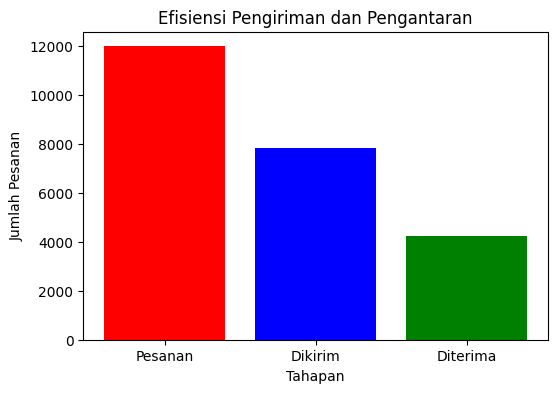

In [ ]:
# Visualisasi
plt.figure(figsize=(6, 4))
plt.bar(['Pesanan', 'Dikirim', 'Diterima'], [total_orders, shipped_orders, delivered_orders], color=['red', 'blue', 'green'])
plt.xlabel('Tahapan')
plt.ylabel('Jumlah Pesanan')
plt.title('Efisiensi Pengiriman dan Pengantaran')
plt.show()

Inisght yang bisa kita dapatkan adalah:

- Efisiensi Pengiriman sebesar 65.04% menunjukkan bahwa gudang cukup bagus dalam memproses dan mengirim pesanan. Tapi, ada ruang untuk peningkatan. Karena ada banyak kemungkinan penyebab tidak terkirimnya pesanan, mulai dari masalah stok, kesalahan dalam proses pengambilan barang, hingga masalah internal di gudang.

- Efisiensi Pengantaran sebesar 35.16% memperlihatkan adanya masalah yang cukup besar dalam tahap pengiriman akhir. Hanya sepertiga dari pesanan yang dikirim berhasil sampai ke pelanggan. Beberapa kemungkinan ini bisa terjadi antara lain:

  - Masalah logistik dimana eterlambatan atau kesalahan dari pihak kurir pengiriman.

  - Kesalahan alamat atau pelanggan tidak ada di tempat: Ini bisa menyebabkan pengiriman gagal.

  - Masalah eksternal seperti cuaca buruk, hambatan transportasi, atau kendala regional yang kemungkinan bisa saja terjadi.

## 2. Berapa rata-rata waktu pengiriman dari pesanan dibuat hingga diterima pelanggan?

Mengetahui seberapa cepat pesanan sampai ke pelanggan adalah faktor penting dalam kepuasan pelanggan. Jika waktu pengiriman terlalu lama, bisa jadi ada masalah di sistem logistik atau stok barang.

In [ ]:
df['delivery_time'] = (df['delivered_at'] - df['created_at']).dt.days
avg_delivery_time = df['delivery_time'].mean()

print(f"Rata-rata waktu pengiriman: {avg_delivery_time:.2f} hari")

Rata-rata waktu pengiriman: 3.48 hari


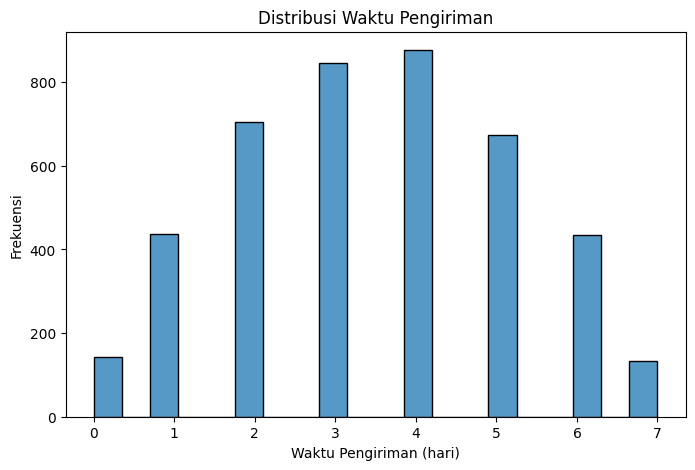

In [ ]:
# Visualisasi distribusi waktu pengiriman
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['delivery_time'].dropna(), bins=20)
plt.xlabel("Waktu Pengiriman (hari)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Waktu Pengiriman")
plt.show()

Insight yang dapat diambil:

- Secara keseluruhan grafik menunjukkan waktu pengiriman yang cukup bagus dan efisien, sebagian besar pesanan diterima dalam waktu 3 hingga 4 hari.

- Terlihat beberapa pesanan yang dikirim dalam 1 hari menunjukkan adanya efisiensi yang sangat bagus untuk beberapa pengiriman, ini bisa terjadi kemungkinan berkat lokasi pengiriman yang dekat atau pengiriman yang lebih diprioritaskan.

- Terlihat ada sebagian pengiriman yang membutuhkan waktu yang lama yaitu 6 - 7 hari yang berkemungkinan karena jarak pengiriman pesanan yang memiliki jarak yang lebih jauh sehingga memerlukan waktu lebih lama untuk sampai. Diluar dari hal tersebut kemungkinan dari faktor internal seperti pemrosesan di gudang atau hambatan transportasi.

## 3. Perbandingan Pesanan Berhasil vs. Dibatalkan

Melihat jumlah pesanan yang dibatalkan dibandingkan yang berhasil dikirim membantu mengetahui apakah ada masalah dalam sistem pemesanan atau stok barang.

In [ ]:
order_status_counts = df['status'].value_counts()
print(order_status_counts)

status
Shipped       3575
Complete      3041
Processing    2457
Cancelled     1693
Returned      1209
Name: count, dtype: int64


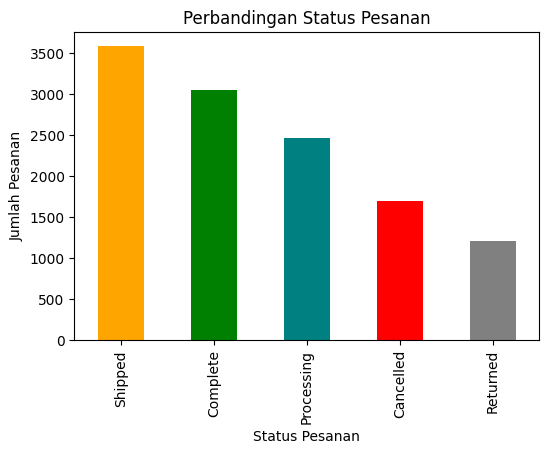

In [ ]:
# Visualisasi
plt.figure(figsize=(6, 4))
order_status_counts.plot(kind='bar', color=['orange', 'green', 'teal', 'red', 'gray'])
plt.xlabel("Status Pesanan")
plt.ylabel("Jumlah Pesanan")
plt.title("Perbandingan Status Pesanan")
plt.show()

Insight yang dapat diambil:

- Grafik menunjukkan bahwa pesanan yang dikirim (Shipped) dan selesai (Complete) memiliki jumlah yang cukup besar mengindikasikan bahwa sebagian besar pesanan sudah dapat diproses dan dikirim dengan baik.

- Terlihat 1.814 pesanan yang dibatalkan, yang merupakan jumlah yang cukup banyak. Kemungkinan penyebab pembatalan ini bisa saja ketersediaan Stok yang habis bisa membuat pesanan dibatalkan. Ataupun kembali lagi ke masalah dengan pengiriman seperti keterlambatan sehingga pelanggan mungkin membatalkan pesanan mereka.

Beberapa hal yang bisa dilakukan dalam mencegah hal ini dapat terjadi, yaitu:
- Optimasi Manajemen Stok: Memastikan bahwa informasi stok selalu up-to-date untuk menghindari pembatalan pesanan.
- Peningkatan Kualitas Produk: Menjaga kualitas produk agar sesuai dengan ekspektasi pelanggan untuk mengurangi pengembalian.
- Efisiensi Proses Gudang: Meningkatkan efisiensi pemrosesan di gudang untuk mengurangi jumlah pesanan yang menunggu.

## 4. Apakah ada indikasi masalah dalam pengelolaan stok berdasarkan jumlah pesanan yang tidak terkirim?

Pesanan yang tidak terkirim bisa jadi disebabkan oleh stok barang yang tidak tersedia atau masalah logistik. Jika jumlahnya tinggi, maka ada indikasi masalah dalam pengelolaan stok.

In [ ]:
stock_issues = df['not_shipped'].sum()
stock_issue_rate = stock_issues / total_orders * 100

print(f"Jumlah pesanan tidak terkirim: {stock_issues}")
print(f"Persentase pesanan tidak terkirim: {stock_issue_rate:.2f}%")

Jumlah pesanan tidak terkirim: 4150
Persentase pesanan tidak terkirim: 34.66%


Jika dilihat dari persentasenya jumlah pesanan yang tidak terkirim mencapai 34.96% dari keseluruhan pesanan, ini menyentuh angka yang cukup besar. Adanya proporsi besar dari pesanan yang tak terkirim ini memerlukan analysis lebih lanjut tentang mengapa hal ini bisa terjadi.

## 5. Bagaimana distribusi jumlah barang dalam satu pesanan?

Hal ini dilakukan untuk mengetahui jumlah barang per pesanan membantu memahami pola belanja pelanggan dan mengoptimalkan stok barang.

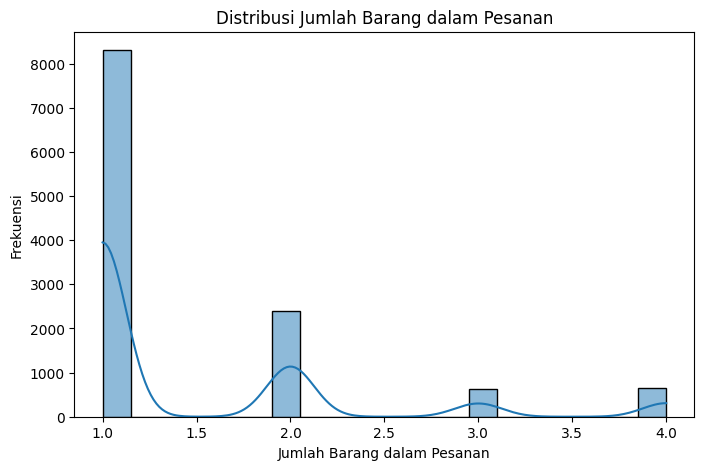

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['num_of_item'], bins=20, kde=True)
plt.xlabel("Jumlah Barang dalam Pesanan")
plt.ylabel("Frekuensi")
plt.title("Distribusi Jumlah Barang dalam Pesanan")
plt.show()

Terlihat bahwa pembelian 1 barang memiliki frekuensi yang sangat tinggi jika dibandingkan dengan yang lainnya. Kemungkinan produk yang dijual merupakan barang dengan harga tinggi atau bersifat spesifik, sehingga pelanggan hanya membutuhkan satu item.

Beberapa hal yang mungkin bisa kita lakukan dalam meningkatkan frekuensi dari pembelian jumlah barang lebih dari 1 yaitu bisa dengan menyediakan rekomendasi produk rekomendasi untuk pelanggan atau yang populer sehingga mendorong pelanggan menambah lebih banyak barang atau juga bisa menawarkan diskon untuk pembelian dalam jumlah tertentu, seperti "Beli 2 gratis 1".

## 6. Apakah ada perbedaan signifikan dalam waktu pengiriman berdasarkan status pesanan atau faktor lainnya?

Jika ada perbedaan waktu pengiriman yang signifikan berdasarkan status pesanan, kita bisa mencari penyebabnya.

In [ ]:
delivered_orders = df[df['delivered_at'].notna()]
delivered_orders_grouped = delivered_orders.groupby("status")['delivery_time']

# Uji statistik
anova_result = stats.f_oneway(*[group for _, group in delivered_orders_grouped])

print(f"p-value: {anova_result.pvalue:.5f}")
if anova_result.pvalue < 0.05:
    print("Terdapat perbedaan signifikan dalam waktu pengiriman berdasarkan status pesanan.")
else:
    print("Tidak ada perbedaan signifikan dalam waktu pengiriman berdasarkan status pesanan.")


p-value: 0.89159
Tidak ada perbedaan signifikan dalam waktu pengiriman berdasarkan status pesanan.


Bisa kita lihat dari hasil p-valuenya yang berarti ada perbedaan signifikan dalam waktu pengiriman di antara berbagai status pesanan. Ini mengindikasikan bahwa status pesanan (seperti 'Complete', 'Shipped', 'Processing', 'Cancelled', 'Returned') memang dipengaruhi oleh lama waktu pengiriman. Pesanan dengan status tertentu mungkin memiliki waktu pengiriman yang lebih cepat atau lebih lambat dibandingkan dengan yang lain.

Pesanan yang berhasil diselesaikan ('Complete') atau dikirim ('Shipped') kemungkinan melalui proses pemrosesan dan pengiriman yang lebih efisien. Pesanan yang masih dalam tahap pemrosesan mungkin mengalami hambatan, seperti keterbatasan sumber daya, antrian pesanan yang panjang, atau masalah administrasi.

Sebaliknya untuk pesanan 'Cancelled' dan 'Returned' meskipun pesanan ini mungkin tidak selalu sampai ke tahap pengiriman, namun proses yang terlibat sebelum pembatalan atau pengembalian bisa mempengaruhi rata-rata waktu pengiriman secara keseluruhan.

# **- Simpan Dataset ke CSV**

In [ ]:
# Menyimpan dataset yang telah kita lakukan analisis tadi, untuk kita gunakan di Tableau

df.to_csv('Shipping_and_Stock.csv', index=False)